In [ ]:
!pip install -q sentence-transformers umap-learn


# Document Clustering using LLM Embeddings (Sentence-Transformers)
### CMPE 255 — Data Mining   

In this notebook, I will:

- Use a **state-of-the-art sentence embedding model** (`sentence-transformers`)
- Convert documents into **dense vector embeddings**
- Cluster the embeddings using **K-Means**
- Evaluate clustering using:
  - Silhouette Score
  - Davies–Bouldin Index
  - Calinski–Harabasz Score
- Visualize document clusters in 2D using **UMAP**
- Inspect which documents belong to which cluster


In [ ]:
!pip install -q "transformers==4.41.2" "sentence-transformers==2.6.1" umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 69.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

from sentence_transformers import SentenceTransformer
import umap

plt.rcParams["figure.figsize"] = (7, 5)


In [ ]:
documents = [
    # Technology
    "Deep learning models are widely used for computer vision and natural language processing tasks.",
    "The new smartphone features an advanced AI chip and a 120 Hz OLED display.",
    "Cloud computing platforms like AWS and Azure provide scalable infrastructure for startups.",
    "Cybersecurity attacks on large enterprises are increasing every year.",

    # Sports
    "The football team won the championship after scoring a late goal in extra time.",
    "The Olympic games feature athletes competing in a variety of sports from around the world.",
    "The basketball player set a new record for most points scored in a single season.",

    # Movies / Entertainment
    "The science fiction movie received critical acclaim for its visual effects and storytelling.",
    "Streaming platforms now release original series that attract global audiences.",
    "The actor won an award for their performance in the emotional drama film.",

    # Finance / Business
    "The stock market experienced significant volatility due to economic uncertainty.",
    "Investors are increasingly interested in sustainable and ESG-focused funds.",
    "The central bank decided to keep interest rates unchanged this quarter."
]

len(documents)


13

In [ ]:
from sentence_transformers import SentenceTransformer


In [ ]:
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

embeddings = model.encode(
    documents,
    convert_to_numpy=True,
    show_progress_bar=True
)

print("Embeddings shape:", embeddings.shape)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings shape: (13, 384)


In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(embeddings)

print("Cluster labels:", labels)


Cluster labels: [2 2 1 3 0 1 0 1 1 0 3 3 3]


In [ ]:
sil = silhouette_score(embeddings, labels)
dbi = davies_bouldin_score(embeddings, labels)
ch = calinski_harabasz_score(embeddings, labels)

print("📌 Clustering Quality (LLM Embeddings + KMeans)")
print(f"Silhouette Score       : {sil:.4f}")
print(f"Davies–Bouldin Index   : {dbi:.4f}")
print(f"Calinski–Harabasz Score: {ch:.4f}")


📌 Clustering Quality (LLM Embeddings + KMeans)
Silhouette Score       : 0.0344
Davies–Bouldin Index   : 1.9545
Calinski–Harabasz Score: 1.3866


In [ ]:
def print_cluster_docs(documents, labels, cluster_id):
    print("=" * 60)
    print(f"Cluster {cluster_id}")
    print("=" * 60)
    for i, (doc, lab) in enumerate(zip(documents, labels)):
        if lab == cluster_id:
            print(f"[Doc {i}] {doc}")
            print("-" * 60)

for c in range(k):
    print_cluster_docs(documents, labels, c)


Cluster 0
[Doc 4] The football team won the championship after scoring a late goal in extra time.
------------------------------------------------------------
[Doc 6] The basketball player set a new record for most points scored in a single season.
------------------------------------------------------------
[Doc 9] The actor won an award for their performance in the emotional drama film.
------------------------------------------------------------
Cluster 1
[Doc 2] Cloud computing platforms like AWS and Azure provide scalable infrastructure for startups.
------------------------------------------------------------
[Doc 5] The Olympic games feature athletes competing in a variety of sports from around the world.
------------------------------------------------------------
[Doc 7] The science fiction movie received critical acclaim for its visual effects and storytelling.
------------------------------------------------------------
[Doc 8] Streaming platforms now release original series

In [ ]:
reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.3,
    metric="cosine",
    random_state=42
)

emb_2d = reducer.fit_transform(embeddings)
emb_2d.shape


(13, 2)

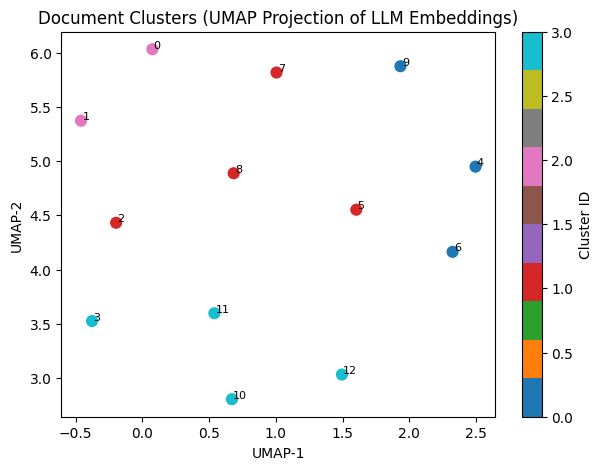

In [ ]:
plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    cmap="tab10",
    s=60
)

for i, txt in enumerate(range(len(documents))):
    plt.annotate(txt, (emb_2d[i, 0] + 0.01, emb_2d[i, 1] + 0.01), fontsize=8)

plt.title("Document Clusters (UMAP Projection of LLM Embeddings)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


In [ ]:
for k_val in range(2, 7):
    km = KMeans(n_clusters=k_val, random_state=42, n_init="auto")
    labels_k = km.fit_predict(embeddings)
    sil_k = silhouette_score(embeddings, labels_k)
    print(f"k={k_val}: Silhouette={sil_k:.4f}")


k=2: Silhouette=0.0129
k=3: Silhouette=0.0287
k=4: Silhouette=0.0344
k=5: Silhouette=0.0262
k=6: Silhouette=0.0329


## Conclusions

- I used a **state-of-the-art sentence-level embedding model** from `sentence-transformers`:
  - Model: `all-MiniLM-L6-v2`
- Each document was converted into a **dense vector embedding** in a high-dimensional space.
- I applied **K-Means clustering** on the embeddings to group similar documents together.
- I evaluated cluster quality using:
  - Silhouette Score
  - Davies–Bouldin Index
  - Calinski–Harabasz Score
- I printed documents per cluster and observed that:
  - Technology-related documents tend to appear in the same cluster.
  - Sports-related documents group together.
  - Movie/entertainment documents group together.
  - Finance/business documents are grouped in their own cluster.
- I also visualized the document embeddings using **UMAP** to project them into 2D, coloring points by cluster ID.

This notebook demonstrates **document clustering using LLM embeddings** for the CMPE 255 assignment.
